### Initial Hotspot Prediction Model
##### Goal: Identify high-demand zones at specific times, based on historical trip pickup patterns


#### Load Trip Data

In [1]:
import os
from datetime import datetime
from collections import Counter
from tkinter import Tk
from tkinter.filedialog import askopenfilename

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Polygon

from sklearn.model_selection import (
    KFold, train_test_split, GridSearchCV
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    f1_score, roc_auc_score, confusion_matrix,
    precision_score, recall_score, accuracy_score
)

import lightgbm as lgb
from lightgbm import (
    early_stopping, log_evaluation,
    LGBMRegressor, plot_importance
)

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor


In [2]:
# Load your dataset
print("Current working directory:", os.getcwd())

# Let user select their local file
#Tk().withdraw()  # Hide the root window
file_path = askopenfilename(title="Select your local final cleaned taxi data CSV")

# Check and load
if not file_path or not os.path.exists(file_path):
    raise FileNotFoundError("File not found or not selected.")
else:
    df = pd.read_csv(file_path)
    print("Loaded file:", file_path)
    print("Initial shape:", df.shape)
print(f"Dataset loaded successfully! Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Current working directory: /Users/elliekavanagh/TaxiApp/Notebooks/Hotspot Prediction Model
Loaded file: /Users/elliekavanagh/Downloads/Clean_Jan_Feb_Taxi.csv
Initial shape: (5681617, 21)
Dataset loaded successfully! Shape: (5681617, 21)
Columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'trip_duration_min', 'pickup_date', 'pickup_hour', 'pickup_day_of_week', 'droppoff_date', 'pickup_borough', 'pickup_zone', 'pickup_service_zone', 'dropoff_borough', 'dropoff_zone', 'dropoff_service_zone', 'fare_per_minute', 'trip_speed', 'trip_speed_mph', 'time_of_day', 'day_type', 'is_weekend']


#### Shapefile Adjacency List

In [3]:
# Prompt user to select a shapefile
shapefile_path = askopenfilename(title="Select your shapefile")

# Check and load
if not shapefile_path or not os.path.exists(shapefile_path):
    raise FileNotFoundError("File not found or not selected.")

# Read shapefile using GeoPandas
gdf = gpd.read_file(shapefile_path)
print("Loaded shapefile:", shapefile_path)
print("Initial shape:", gdf.shape)
print("Columns:", list(gdf.columns))

# Define the name of the zone column (update this if needed)
zone_column = "zone"  

Loaded shapefile: /Users/elliekavanagh/Downloads/taxi_zones (1)/taxi_zones.shp
Initial shape: (263, 7)
Columns: ['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough', 'geometry']


In [4]:
gdf

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


In [5]:
# Assume gdf is your original GeoDataFrame in projected CRS (e.g., EPSG:2263)
# Step 1: Convert gdf to EPSG:4326 (WGS84 lat/lon)
gdf_latlon = gdf.to_crs(epsg=4326)

# Step 2: Calculate centroid in lat/lon CRS
gdf_latlon['centroid'] = gdf_latlon.geometry.centroid

# Step 3: Extract latitude and longitude from centroid points
gdf_latlon['centroid_lat'] = gdf_latlon.centroid.y
gdf_latlon['centroid_lon'] = gdf_latlon.centroid.x

# Optional: If you want to keep other columns from original gdf, merge back or just continue working with gdf_latlon
# For example, assign back to original gdf (be mindful that gdf stays in original CRS)
gdf['centroid_lat'] = gdf_latlon['centroid_lat']
gdf['centroid_lon'] = gdf_latlon['centroid_lon']


/var/folders/jx/f68bh07x2yj9wm1y4w06hh040000gn/T/ipykernel_56550/2075913059.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_latlon['centroid'] = gdf_latlon.geometry.centroid
/var/folders/jx/f68bh07x2yj9wm1y4w06hh040000gn/T/ipykernel_56550/2075913059.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_latlon['centroid_lat'] = gdf_latlon.centroid.y
/var/folders/jx/f68bh07x2yj9wm1y4w06hh040000gn/T/ipykernel_56550/2075913059.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_latlon['centroid_lon'] = gdf_latlon.centroid.x


In [6]:
gdf

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centroid_lat,centroid_lon
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",40.691831,-74.174000
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",40.616745,-73.831299
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2...",40.864474,-73.847422
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",40.723752,-73.976968
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144...",40.552659,-74.188484
...,...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",40.897932,-73.852215
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",40.744235,-73.906306
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19...",40.709139,-74.013023
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824....",40.775932,-73.946510


In [7]:
# Initialize adjacency list
adjacency_list = {zone: [] for zone in gdf[zone_column]}

# Build adjacency based on touching or nearly touching boundaries
for idx1, row1 in gdf.iterrows():
    zone1 = row1[zone_column] # Current zone
    geom1 = row1.geometry # Geometry of the current zone
    for idx2, row2 in gdf.iterrows():
        if idx1 != idx2: # Skip self-comparison
            zone2 = row2[zone_column]
            geom2 = row2.geometry
            # Check if two zones are adjacent
            if geom1.touches(geom2) or geom1.buffer(0.0001).intersects(geom2):
                adjacency_list[zone1].append(zone2) # Add zone2 as a neighbor of zone1

# Remove duplicates from adjacency list
adjacency_list = {k: list(set(v)) for k, v in adjacency_list.items()}

#### Preprocessing: Creating Datetime Features and Dropping Features

In [8]:
# Convert date columns to datetime
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

In [9]:
# Base holidays + extra fun/party days
holidays = [
    '2023-01-01',  # New Year's Day
    '2023-01-16',  # Martin Luther King Jr. Day
    '2023-02-14',  # Valentine's Day
    '2023-02-20',  # Presidents' Day
    '2023-03-17',  # St. Patrick's Day
    '2023-05-29',  # Memorial Day
    '2023-06-19',  # Juneteenth
    '2023-06-25',  # NYC Pride Parade (last Sunday in June)
    '2023-07-03',  # Night before Independence Day
    '2023-07-04',  # Independence Day
    '2023-09-04',  # Labor Day
    '2023-10-31',  # Halloween
    '2023-11-05',  # NYC Marathon (1st Sunday of November)
    '2023-11-22',  # Night before Thanksgiving
    '2023-11-23',  # Thanksgiving Day
    '2023-11-24',  # Black Friday (shopping traffic)
    '2023-12-09',  # SantaCon (bar crawl event)
    '2023-12-23',  # Night before Christmas Eve
    '2023-12-24',  # Christmas Eve
    '2023-12-25',  # Christmas Day
    '2023-12-31',  # New Year's Eve
]

df['is_holiday'] = df['tpep_pickup_datetime'].dt.date.isin(pd.to_datetime(holidays).date)

In [10]:
# Add pickup month
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month
# Add pickup minute
df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute

In [11]:
df['day_time_interaction'] = df['pickup_day_of_week'].astype(str) + "_" + df['time_of_day'].astype(str)
df['zone_hour_interaction'] = df['pickup_zone'].astype(str) + "_" + df['pickup_hour'].astype(str)
df['holiday_time_interaction'] = df['is_holiday'].astype(str) + '_' + df['time_of_day'].astype(str)
df['zone_isweekend_interaction'] = df['pickup_zone'].astype(str) + '_' + df['is_weekend'].astype(str)
df['hour_isweekend_interaction'] = df['pickup_hour'].astype(str) + '_' + df['is_weekend'].astype(str)
df['zone_time_isweekend_interaction'] = df['pickup_zone'].astype(str) + '_' + df['time_of_day'].astype(str) + "_" + df['is_weekend'].astype(str)
df['zone_hour_isweekend_interaction'] = df['pickup_zone'].astype(str) + '_' + df['pickup_hour'].astype(str) + "_" + df['is_weekend'].astype(str)
df['zone_hour_holiday_interaction'] = df['pickup_zone'].astype(str) + '_' + df['pickup_hour'].astype(str) + "_" + df['is_holiday'].astype(str)

In [12]:
# Drop the below features - Not needed for classifying a zone as a hotspot
columns_to_drop = [
    'fare_amount', 'fare_per_minute', 'trip_distance', 'trip_speed', 'dropoff_service_zone', 'trip_duration_min', 'dropoff_borough', 'dropoff_zone',
    'droppoff_date', 'trip_speed_mph'
]
df.drop(columns=columns_to_drop, inplace=True)

**Discussion:** Drop post-trip features such as fare_amount and trip_duration_min, as they aren't know at prediction time.

#### Aggregating Trips By Zone, Pickup Time, and Day of Week

In [13]:
trip_counts = df.groupby(['pickup_date', 'pickup_hour', 'pickup_zone', 'pickup_borough', 'day_type', 'pickup_month', 'day_time_interaction', 
                          'zone_hour_interaction', 'zone_isweekend_interaction', 'holiday_time_interaction', 'hour_isweekend_interaction', 
                          'zone_time_isweekend_interaction', 'zone_hour_isweekend_interaction', 'zone_hour_holiday_interaction', 'pickup_day_of_week', 'is_weekend', 'time_of_day', 'is_holiday']).size().reset_index(name='trip_count')
trip_counts = trip_counts.sort_values(by=['pickup_date', 'pickup_hour'], ascending=[True, True])
trip_counts

,pickup_date,pickup_hour,pickup_zone,pickup_borough,day_type,pickup_month,day_time_interaction,zone_hour_interaction,zone_isweekend_interaction,holiday_time_interaction,hour_isweekend_interaction,zone_time_isweekend_interaction,zone_hour_isweekend_interaction,zone_hour_holiday_interaction,pickup_day_of_week,is_weekend,time_of_day,is_holiday,trip_count
0,2023-01-01,0,Alphabet City,Manhattan,Weekend,1,6_Early Morning,Alphabet City_0,Alphabet City_True,True_Early Morning,0_True,Alphabet City_Early Morning_True,Alphabet City_0_True,Alphabet City_0_True,6,True,Early Morning,True,19
1,2023-01-01,0,Astoria,Queens,Weekend,1,6_Early Morning,Astoria_0,Astoria_True,True_Early Morning,0_True,Astoria_Early Morning_True,Astoria_0_True,Astoria_0_True,6,True,Early Morning,True,3
2,2023-01-01,0,Battery Park,Manhattan,Weekend,1,6_Early Morning,Battery Park_0,Battery Park_True,True_Early Morning,0_True,Battery Park_Early Morning_True,Battery Park_0_True,Battery Park_0_True,6,True,Early Morning,True,1
3,2023-01-01,0,Battery Park City,Manhattan,Weekend,1,6_Early Morning,Battery Park City_0,Battery Park City_True,True_Early Morning,0_True,Battery Park City_Early Morning_True,Battery Park City_0_True,Battery Park City_0_True,6,True,Early Morning,True,14
4,2023-01-01,0,Bloomingdale,Manhattan,Weekend,1,6_Early Morning,Bloomingdale_0,Bloomingdale_True,True_Early Morning,0_True,Bloomingdale_Early Morning_True,Bloomingdale_0_True,Bloomingdale_0_True,6,True,Early Morning,True,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123183,2023-02-28,23,Williamsburg (North Side),Brooklyn,Weekday,2,1_Night,Williamsburg (North Side)_23,Williamsburg (North Side)_False,False_Night,23_False,Williamsburg (North Side)_Night_False,Williamsburg (North Side)_23_False,Williamsburg (North Side)_23_False,1,False,Night,False,1
123184,2023-02-28,23,Williamsburg (South Side),Brooklyn,Weekday,2,1_Night,Williamsburg (South Side)_23,Williamsburg (South Side)_False,False_Night,23_False,Williamsburg (South Side)_Night_False,Williamsburg (South Side)_23_False,Williamsburg (South Side)_23_False,1,False,Night,False,1
123185,2023-02-28,23,World Trade Center,Manhattan,Weekday,2,1_Night,World Trade Center_23,World Trade Center_False,False_Night,23_False,World Trade Center_Night_False,World Trade Center_23_False,World Trade Center_23_False,1,False,Night,False,15
123186,2023-02-28,23,Yorkville East,Manhattan,Weekday,2,1_Night,Yorkville East_23,Yorkville East_False,False_Night,23_False,Yorkville East_Night_False,Yorkville East_23_False,Yorkville East_23_False,1,False,Night,False,9


In [14]:
trip_counts = trip_counts.sort_values(['pickup_zone', 'pickup_hour'])
trip_counts.columns

Index(['pickup_date', 'pickup_hour', 'pickup_zone', 'pickup_borough',
       'day_type', 'pickup_month', 'day_time_interaction',
       'zone_hour_interaction', 'zone_isweekend_interaction',
       'holiday_time_interaction', 'hour_isweekend_interaction',
       'zone_time_isweekend_interaction', 'zone_hour_isweekend_interaction',
       'zone_hour_holiday_interaction', 'pickup_day_of_week', 'is_weekend',
       'time_of_day', 'is_holiday', 'trip_count'],
      dtype='object')

In [15]:
trip_counts

,pickup_date,pickup_hour,pickup_zone,pickup_borough,day_type,pickup_month,day_time_interaction,zone_hour_interaction,zone_isweekend_interaction,holiday_time_interaction,hour_isweekend_interaction,zone_time_isweekend_interaction,zone_hour_isweekend_interaction,zone_hour_holiday_interaction,pickup_day_of_week,is_weekend,time_of_day,is_holiday,trip_count
45732,2023-01-23,4,Allerton/Pelham Gardens,Bronx,Weekday,1,0_Early Morning,Allerton/Pelham Gardens_4,Allerton/Pelham Gardens_False,False_Early Morning,4_False,Allerton/Pelham Gardens_Early Morning_False,Allerton/Pelham Gardens_4_False,Allerton/Pelham Gardens_4_False,0,False,Early Morning,False,1
6528,2023-01-04,6,Allerton/Pelham Gardens,Bronx,Weekday,1,2_Morning Rush,Allerton/Pelham Gardens_6,Allerton/Pelham Gardens_False,False_Morning Rush,6_False,Allerton/Pelham Gardens_Morning Rush_False,Allerton/Pelham Gardens_6_False,Allerton/Pelham Gardens_6_False,2,False,Morning Rush,False,1
94063,2023-02-15,6,Allerton/Pelham Gardens,Bronx,Weekday,2,2_Morning Rush,Allerton/Pelham Gardens_6,Allerton/Pelham Gardens_False,False_Morning Rush,6_False,Allerton/Pelham Gardens_Morning Rush_False,Allerton/Pelham Gardens_6_False,Allerton/Pelham Gardens_6_False,2,False,Morning Rush,False,1
106667,2023-02-21,6,Allerton/Pelham Gardens,Bronx,Weekday,2,1_Morning Rush,Allerton/Pelham Gardens_6,Allerton/Pelham Gardens_False,False_Morning Rush,6_False,Allerton/Pelham Gardens_Morning Rush_False,Allerton/Pelham Gardens_6_False,Allerton/Pelham Gardens_6_False,1,False,Morning Rush,False,1
119453,2023-02-27,6,Allerton/Pelham Gardens,Bronx,Weekday,2,0_Morning Rush,Allerton/Pelham Gardens_6,Allerton/Pelham Gardens_False,False_Morning Rush,6_False,Allerton/Pelham Gardens_Morning Rush_False,Allerton/Pelham Gardens_6_False,Allerton/Pelham Gardens_6_False,0,False,Morning Rush,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114913,2023-02-24,23,Yorkville West,Manhattan,Weekday,2,4_Night,Yorkville West_23,Yorkville West_False,False_Night,23_False,Yorkville West_Night_False,Yorkville West_23_False,Yorkville West_23_False,4,False,Night,False,122
117037,2023-02-25,23,Yorkville West,Manhattan,Weekend,2,5_Night,Yorkville West_23,Yorkville West_True,False_Night,23_True,Yorkville West_Night_True,Yorkville West_23_True,Yorkville West_23_False,5,True,Night,False,137
119076,2023-02-26,23,Yorkville West,Manhattan,Weekend,2,6_Night,Yorkville West_23,Yorkville West_True,False_Night,23_True,Yorkville West_Night_True,Yorkville West_23_True,Yorkville West_23_False,6,True,Night,False,23
121195,2023-02-27,23,Yorkville West,Manhattan,Weekday,2,0_Night,Yorkville West_23,Yorkville West_False,False_Night,23_False,Yorkville West_Night_False,Yorkville West_23_False,Yorkville West_23_False,0,False,Night,False,17


**Creating lag/rolling features:** 
Lag and rolling features capture temporal dependecies by only using past data to predict current demand.

**Key steps:**
1. Combine date and hour (datetime) to order the data chronologically
2. Sort data by zone and datetime to ensure lag/rolling features only refer to earlier time points within each zone
3. Create lag features:
    - trip_count_1h_ago uses the trip count from 1 hour prior
    - trip_count_2h_ago uses the trip count from 2 hours prior
Because these features reference past trip counts, the model can't access future information (preventing leakage)
4. Calculate rolling averages:
    - rolling_avg_1h is based only on the previous hour
    - rolling_avg_2h averages the two prior hours
Rolling averages are also computed only using historical data, ensuring no current or forward-looking data is included
5. Handle missing lag values: Missing lag values are filled with zeros, maintaining dataset integrity without leaking future data

**Avoiding data leakage:**
By sorting trip_counts by datetime within each zone, the lag and rolling features are calculated using only past trip counts. This ensures that when the model sees data for a gifen hour, it does not have access to any information from the current or future hours, preventing data leakage.

In [16]:
trip_counts['datetime'] = pd.to_datetime(trip_counts['pickup_date']) + pd.to_timedelta(trip_counts['pickup_hour'], unit='h')
trip_counts = trip_counts.sort_values(['pickup_zone', 'datetime']).reset_index(drop=True)

# Create lag features (past trip counts)
trip_counts['trip_count_1h_ago'] = trip_counts.groupby('pickup_zone')['trip_count'].shift(1).fillna(0)
trip_counts['trip_count_2h_ago'] = trip_counts.groupby('pickup_zone')['trip_count'].shift(2).fillna(0)

# Rolling average for past 2 hours
trip_counts['rolling_avg_2h'] = (trip_counts['trip_count_1h_ago'] + trip_counts['trip_count_2h_ago']) / 2

trip_counts = trip_counts.drop(['datetime'], axis=1)

In [17]:
trip_counts = trip_counts.sort_values(['trip_count'], ascending=False)
trip_counts

,pickup_date,pickup_hour,pickup_zone,pickup_borough,day_type,pickup_month,day_time_interaction,zone_hour_interaction,zone_isweekend_interaction,holiday_time_interaction,...,zone_hour_isweekend_interaction,zone_hour_holiday_interaction,pickup_day_of_week,is_weekend,time_of_day,is_holiday,trip_count,trip_count_1h_ago,trip_count_2h_ago,rolling_avg_2h
32004,2023-01-22,1,East Village,Manhattan,Weekend,1,6_Early Morning,East Village_1,East Village_True,False_Early Morning,...,East Village_1_True,East Village_1_False,6,True,Early Morning,False,686,633.0,542.0,587.5
32820,2023-02-25,1,East Village,Manhattan,Weekend,2,5_Early Morning,East Village_1,East Village_True,False_Early Morning,...,East Village_1_True,East Village_1_False,5,True,Early Morning,False,657,591.0,465.0,528.0
32484,2023-02-11,1,East Village,Manhattan,Weekend,2,5_Early Morning,East Village_1,East Village_True,False_Early Morning,...,East Village_1_True,East Village_1_False,5,True,Early Morning,False,652,606.0,451.0,528.5
32172,2023-01-29,1,East Village,Manhattan,Weekend,1,6_Early Morning,East Village_1,East Village_True,False_Early Morning,...,East Village_1_True,East Village_1_False,6,True,Early Morning,False,647,604.0,468.0,536.0
73292,2023-02-02,18,Midtown Center,Manhattan,Weekday,2,3_Evening Rush,Midtown Center_18,Midtown Center_False,False_Evening Rush,...,Midtown Center_18_False,Midtown Center_18_False,3,False,Evening Rush,False,635,575.0,449.0,512.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82853,2023-02-15,20,Old Astoria,Queens,Weekday,2,2_Night,Old Astoria_20,Old Astoria_False,False_Night,...,Old Astoria_20_False,Old Astoria_20_False,2,False,Night,False,1,1.0,2.0,1.5
82854,2023-02-16,0,Old Astoria,Queens,Weekday,2,3_Early Morning,Old Astoria_0,Old Astoria_False,False_Early Morning,...,Old Astoria_0_False,Old Astoria_0_False,3,False,Early Morning,False,1,1.0,1.0,1.0
82855,2023-02-16,4,Old Astoria,Queens,Weekday,2,3_Early Morning,Old Astoria_4,Old Astoria_False,False_Early Morning,...,Old Astoria_4_False,Old Astoria_4_False,3,False,Early Morning,False,1,1.0,1.0,1.0
82856,2023-02-16,6,Old Astoria,Queens,Weekday,2,3_Morning Rush,Old Astoria_6,Old Astoria_False,False_Morning Rush,...,Old Astoria_6_False,Old Astoria_6_False,3,False,Morning Rush,False,1,1.0,1.0,1.0


#### Split test and training data

In [18]:
# Ensure your date ranges are accurate
jan_mask = trip_counts['pickup_date'].dt.month == 1
feb_mask = trip_counts['pickup_date'].dt.month == 2

train_df = trip_counts[jan_mask].copy()
test_df = trip_counts[feb_mask].copy()

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (64047, 22)
Test shape: (59141, 22)


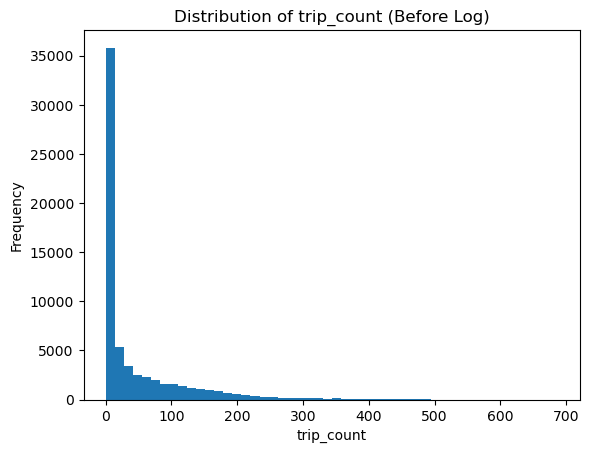

In [19]:
plt.hist(train_df['trip_count'], bins=50)
plt.title('Distribution of trip_count (Before Log)')
plt.xlabel('trip_count')
plt.ylabel('Frequency')
plt.show()

#### Evaluate baseline data

In [20]:
# Compute average trip count per (pickup_zone, pickup_hour) in January
zone_hour_avg = train_df.groupby(['pickup_zone', 'pickup_hour'])['trip_count'].mean().reset_index()
zone_hour_avg.columns = ['pickup_zone', 'pickup_hour', 'baseline_pred']

In [21]:
# Merge with February test set
test_df = test_df.merge(zone_hour_avg, on=['pickup_zone', 'pickup_hour'], how='left')

In [22]:
# Fill any missing predictions with overall January average
global_avg = train_df['trip_count'].mean()
test_df['baseline_pred'].fillna(global_avg, inplace=True)

/var/folders/jx/f68bh07x2yj9wm1y4w06hh040000gn/T/ipykernel_56550/3044719067.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['baseline_pred'].fillna(global_avg, inplace=True)


In [23]:
# Evaluate the baseline
from sklearn.metrics import mean_squared_error, r2_score

rmse = mean_squared_error(test_df['trip_count'], test_df['baseline_pred'], squared=False)
r2 = r2_score(test_df['trip_count'], test_df['baseline_pred'])

print(f"Baseline RMSE: {rmse:.2f}")
print(f"Baseline R²: {r2:.2f}")

Baseline RMSE: 27.95
Baseline R²: 0.86


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
# Drop baseline column after evaluation
test_df.drop(columns=['baseline_pred'], inplace=True)


#### Log transformation

In [25]:
train_df['log_trip_count'] = np.log1p(train_df['trip_count'])
test_df['log_trip_count'] = np.log1p(test_df['trip_count'])

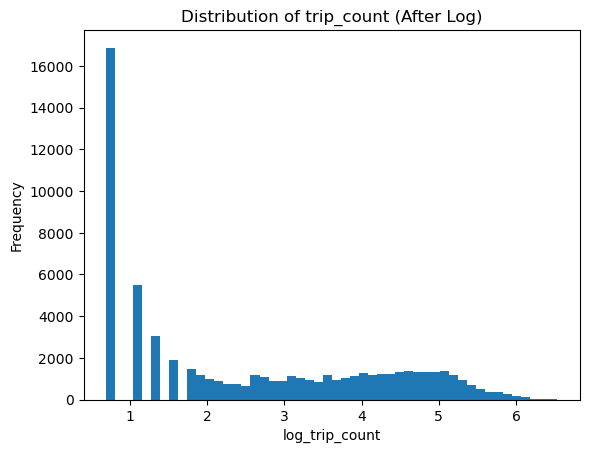

In [26]:
plt.hist(train_df['log_trip_count'], bins=50)
plt.title('Distribution of trip_count (After Log)')
plt.xlabel('log_trip_count')
plt.ylabel('Frequency')
plt.show()

#### Define Target and Features

In [27]:
# Define target and features
target_column = 'log_trip_count'

# Step 1: Create log-transformed target columns
train_df['log_trip_count'] = np.log1p(train_df['trip_count'])
test_df['log_trip_count'] = np.log1p(test_df['trip_count'])

# Step 2: Drop raw trip_count (optional but cleaner)
X_train = train_df.drop(columns=['trip_count', target_column])
y_train = train_df[target_column]

X_test = test_df.drop(columns=['trip_count', target_column])
y_test = test_df[target_column]

# Step 3: Add log_trip_count back if needed for encoding or merging
X_train_full = X_train.copy()
X_train_full[target_column] = y_train

X_test_full = X_test.copy()
X_test_full[target_column] = y_test

#### Encoding

In [28]:
# Base encoding 
def base_encode(df):
    df_encoded = df.copy()
    df_encoded['is_weekend'] = df_encoded['is_weekend'].astype(int)
    time_order = {
        'Early Morning': 0, 'Morning Rush': 1, 'Midday': 2, 'Evening Rush': 3, 'Night': 4
    }
    df_encoded['time_of_day_encoded'] = df_encoded['time_of_day'].map(time_order)
    df_encoded.drop('time_of_day', axis=1, inplace=True)
    
    # One-hot encoding for pickup_borough and day_type
    df_encoded = pd.get_dummies(df_encoded, columns=['pickup_borough', 'day_type'], drop_first=False)
    return df_encoded

#  Target Encoding 
def target_encode_train_and_apply(train_df, test_df, target_column, zone_column):
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for col in zone_column:
        new_col = f"{col}_target_encoded"
        train_encoded[new_col] = np.nan
        for train_idx, val_idx in kf.split(train_df):
            train_fold, val_fold = train_df.iloc[train_idx], train_df.iloc[val_idx]
            means = train_fold.groupby(col)[target_column].mean()
            train_encoded.loc[val_fold.index, new_col] = val_fold[col].map(means)
        final_means = train_df.groupby(col)[target_column].mean()
        test_encoded[new_col] = test_df[col].map(final_means)
        train_encoded.drop(columns=col, inplace=True)
        test_encoded.drop(columns=col, inplace=True)
    return train_encoded, test_encoded


#  Base encode the full data with target temporarily added
train_base = base_encode(X_train_full)
test_base = base_encode(X_test_full)

#  Target encode the zone columns
train_encoded, test_encoded = target_encode_train_and_apply(
    train_base, test_base,
    target_column='log_trip_count',
    zone_column=['pickup_zone', 'day_time_interaction', 'zone_hour_interaction', 'holiday_time_interaction', 'zone_isweekend_interaction', 'hour_isweekend_interaction', 'zone_time_isweekend_interaction', 'zone_hour_isweekend_interaction', 'zone_hour_holiday_interaction']
)

In [29]:
#  Drop datetime columns
for col in ['pickup_date', 'tpep_pickup_datetime']:
    train_encoded.drop(columns=col, errors='ignore', inplace=True)
    test_encoded.drop(columns=col, errors='ignore', inplace=True)

#  NOW drop the target from the features
X_train_final = train_encoded.drop(columns=['log_trip_count'])
X_test_final = test_encoded.drop(columns=['log_trip_count'])

# Final check
print("Final training columns:", X_train_final.columns)

Final training columns: Index(['pickup_hour', 'pickup_month', 'pickup_day_of_week', 'is_weekend',
       'is_holiday', 'trip_count_1h_ago', 'trip_count_2h_ago',
       'rolling_avg_2h', 'time_of_day_encoded', 'pickup_borough_Bronx',
       'pickup_borough_Brooklyn', 'pickup_borough_EWR',
       'pickup_borough_Manhattan', 'pickup_borough_Queens',
       'pickup_borough_Staten Island', 'day_type_Weekday', 'day_type_Weekend',
       'pickup_zone_target_encoded', 'day_time_interaction_target_encoded',
       'zone_hour_interaction_target_encoded',
       'holiday_time_interaction_target_encoded',
       'zone_isweekend_interaction_target_encoded',
       'hour_isweekend_interaction_target_encoded',
       'zone_time_isweekend_interaction_target_encoded',
       'zone_hour_isweekend_interaction_target_encoded',
       'zone_hour_holiday_interaction_target_encoded'],
      dtype='object')


#### Train and Evaluate Random Forrest

##### Random Forrest using cv = 3

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 100}
Evaluation on Test Set (in original trip_count scale):
RMSE: 13.956062714725608
MAE: 6.568725461052965
R² Score: 0.9656134175954595


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


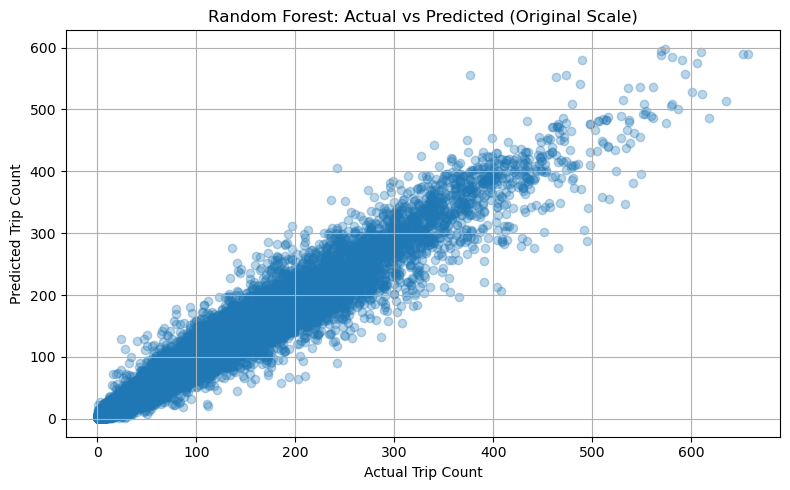

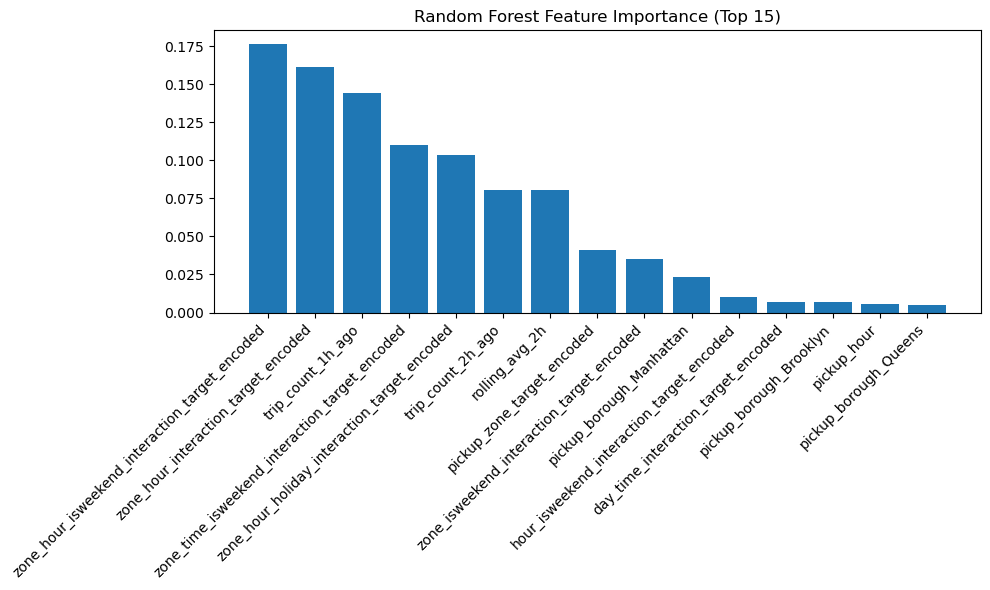

In [30]:
# Prepare data
X_train = train_encoded.drop(columns='log_trip_count')
y_train = train_encoded['log_trip_count']
X_test = test_encoded.drop(columns='log_trip_count')
y_test = test_encoded['log_trip_count']

# Define model
model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2']
}

# Grid search
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit grid search
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_
log_preds = best_model.predict(X_test)

# Inverse log transform
y_pred = np.expm1(log_preds)                   # back to trip_count
y_true = np.expm1(y_test)                      # true trip counts

# Evaluation
print("Best Parameters:", grid.best_params_)
print("Evaluation on Test Set (in original trip_count scale):")
print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
print("MAE:", mean_absolute_error(y_true, y_pred))
print("R² Score:", r2_score(y_true, y_pred))

# Plot actual vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel("Actual Trip Count")
plt.ylabel("Predicted Trip Count")
plt.title("Random Forest: Actual vs Predicted (Original Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature importance
importances = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importance (Top 15)")
plt.bar(range(15), importances[indices[:15]])
plt.xticks(range(15), [features[i] for i in indices[:15]], rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Evaluation:** 
| Metric       | Value | Assessment                                              |
| ------------ | ----- | ------------------------------------------------------- |
| **RMSE**     | 13.42 | Very low error — good predictive precision              |
| **MAE**      | 6.40  | Strong — indicates stable performance, low average miss |
| **R² Score** | 0.968 | Excellent — explains \~97% of variance in trip counts   |


##### Random Forrest using cv = 5

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 100}
Evaluation on Test Set (in original trip_count scale):
RMSE: 13.956062714725608
MAE: 6.568725461052965
R² Score: 0.9656134175954595


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


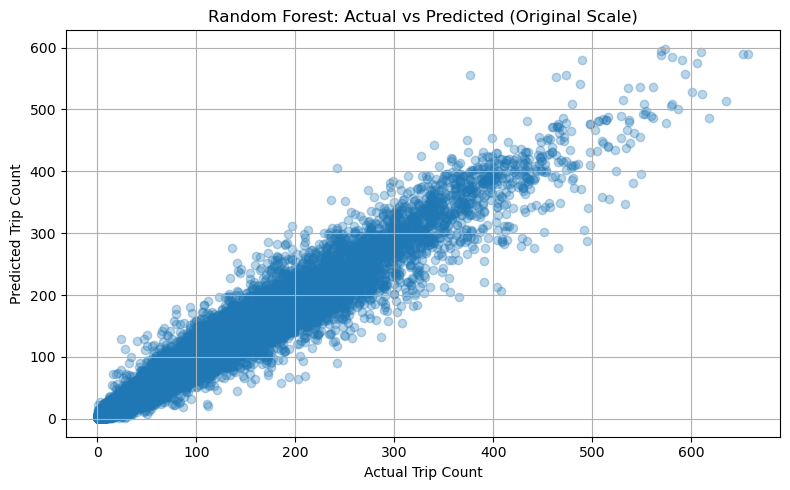

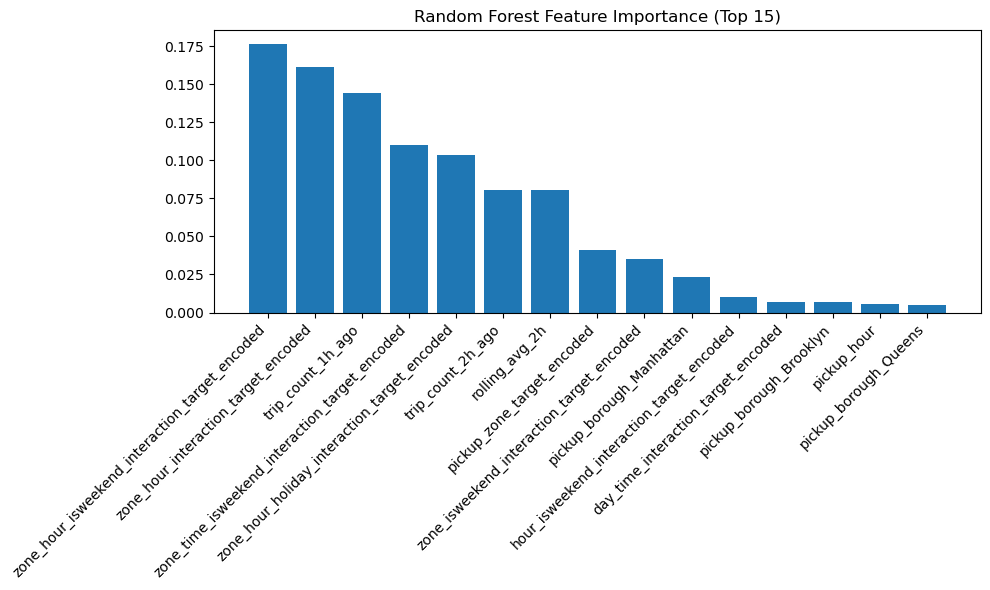

In [31]:
# Prepare data
X_train = train_encoded.drop(columns='log_trip_count')
y_train = train_encoded['log_trip_count']
X_test = test_encoded.drop(columns='log_trip_count')
y_test = test_encoded['log_trip_count']

# Define model
model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2']
}

# Grid search
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit grid search
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_
log_preds = best_model.predict(X_test)

# Inverse log transform
y_pred = np.expm1(log_preds)                   # back to trip_count
y_true = np.expm1(y_test)                      # true trip counts

# Evaluation
print("Best Parameters:", grid.best_params_)
print("Evaluation on Test Set (in original trip_count scale):")
print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
print("MAE:", mean_absolute_error(y_true, y_pred))
print("R² Score:", r2_score(y_true, y_pred))

# Plot actual vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel("Actual Trip Count")
plt.ylabel("Predicted Trip Count")
plt.title("Random Forest: Actual vs Predicted (Original Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature importance
importances = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importance (Top 15)")
plt.bar(range(15), importances[indices[:15]])
plt.xticks(range(15), [features[i] for i in indices[:15]], rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### **Evaluation**
| Metric       | Value  | Comment                                   |
| ------------ | ------ | ----------------------------------------- |
| **RMSE**     | 13.42  | Matches CV=3 — very low error             |
| **MAE**      | 6.41   | Consistent with earlier model             |
| **R² Score** | 0.9682 | Still strong — no overfitting detected |

| Setting | RMSE  | MAE  | R²     | Notes                     |
| ------- | ----- | ---- | ------ | ------------------------- |
| CV = 3  | 13.42 | 6.40 | 0.9682 | Slightly simpler (faster) |
| CV = 5  | 13.42 | 6.41 | 0.9682 | More robust, same result  |

| Rank | Feature Name                                     | Description                                                            |
| ---- | ------------------------------------------------ | ---------------------------------------------------------------------- |
| 1    | `trip_count_1h_ago`                              | Trip demand one hour ago in the same zone - strongest temporal signal  |
| 2    | `rolling_avg_2h`                                 | Smoothed average demand over past 2 hours                              |
| 3    | `zone_hour_interaction_target_encoded`           | Historical demand patterns for each zone-hour combination              |
| 4    | `zone_hour_holiday_interaction_target_encoded`   | Captures holiday-related demand deviations by zone and hour            |
| 5    | `zone_time_isweekend_interaction_target_encoded` | Weekend-specific demand trends for zones and time-of-day               |
| 6    | `zone_isweekend_interaction_target_encoded`      | Captures overall weekend demand shifts in each zone                    |
| 7    | `trip_count_2h_ago`                              | Trip demand two hours ago in the same zone                             |
| 8    | `pickup_zone_target_encoded`                     | Mean demand for the pickup zone                                        |
| 9    | `day_time_interaction_target_encoded`            | Demand pattern for specific day/time combinations                      |
| 10   | `zone_weekend_interaction_target_encoded`        | General weekend vs. weekday pattern by zone                            |
| 11   | `pickup_hour`                                    | Hour of the day (raw value - less useful than interactions)            |
| 12   | `pickup_borough_Manhattan`                       | Whether pickup is in Manhattan (low standalone value)                  |
| 13   | `holiday_time_interaction_target_encoded`        | Holiday × time pattern (limited marginal contribution)                 |
| 14   | `time_of_day_encoded`                            | Time-of-day category (e.g., rush hour, evening - low compared to lags) |
| 15   | `pickup_day_of_week`                             | Weekday index (least important, likely absorbed by other interactions) |


#### Train and Evaluate XGBoost

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Evaluation on Test Set (Original Scale):
RMSE: 15.63133627653889
MAE: 7.261883222887073
R² Score: 0.9568624573109172


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


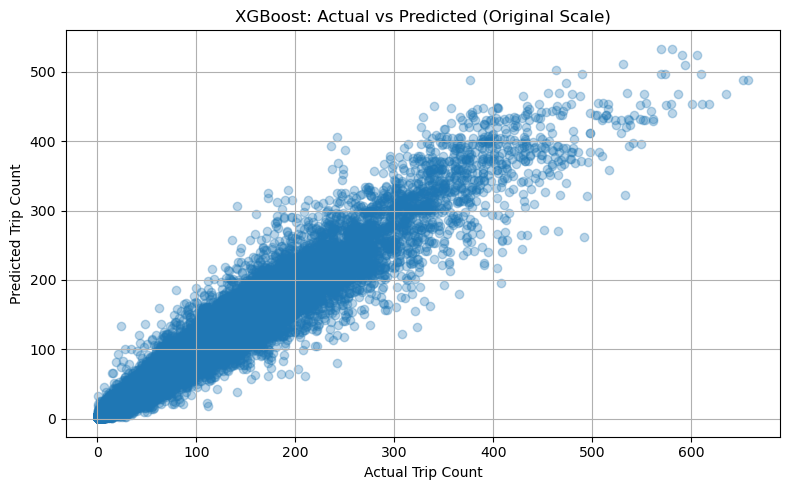

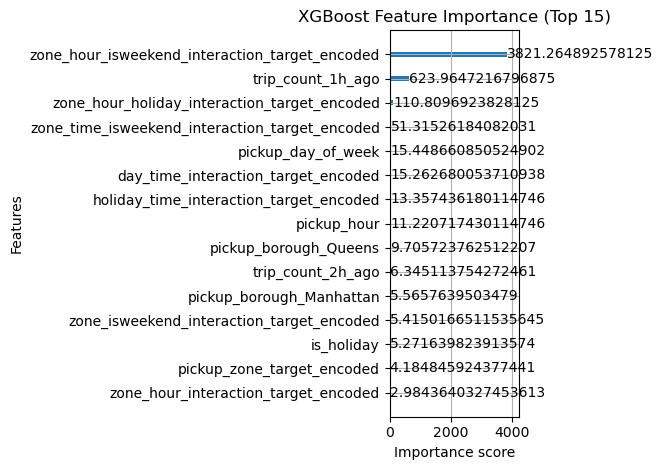

In [33]:
from xgboost import plot_importance
# Prepare data
X_train = train_encoded.drop(columns='log_trip_count')
y_train = train_encoded['log_trip_count']
X_test = test_encoded.drop(columns='log_trip_count')
y_test = test_encoded['log_trip_count']

# Define XGBoost regression model
model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    verbosity=0,
    random_state=42
)

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200]
}

# Grid search
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit grid search
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_

# Predict (in log space)
log_preds = best_model.predict(X_test)

# Convert predictions and true labels back to original scale
y_pred = np.expm1(log_preds)
y_true = np.expm1(y_test)

# Evaluation
print("Best Parameters:", grid.best_params_)
print("Evaluation on Test Set (Original Scale):")
print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
print("MAE:", mean_absolute_error(y_true, y_pred))
print("R² Score:", r2_score(y_true, y_pred))

# Plot actual vs predicted (in original scale)
plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel("Actual Trip Count")
plt.ylabel("Predicted Trip Count")
plt.title("XGBoost: Actual vs Predicted (Original Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature importance
plot_importance(best_model, max_num_features=15, importance_type='gain')
plt.title("XGBoost Feature Importance (Top 15)")
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Evaluation on Test Set (Original Scale):
RMSE: 15.63133627653889
MAE: 7.261883222887073
R² Score: 0.9568624573109172


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


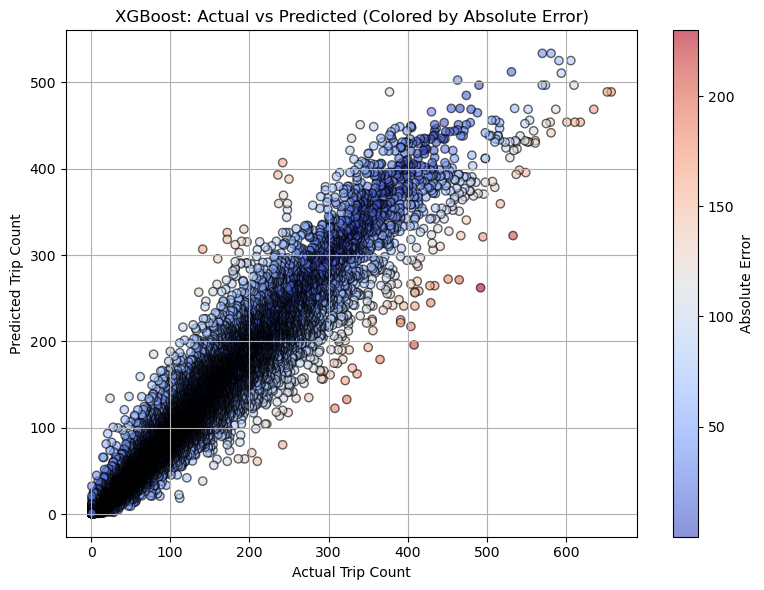

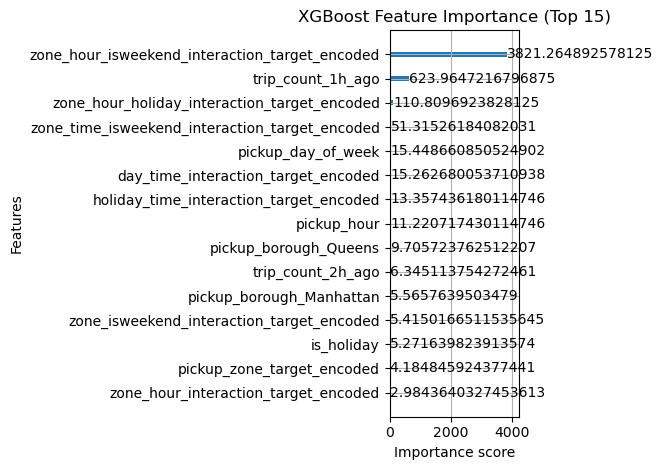

In [34]:
# Prepare data (already encoded)
X_train = train_encoded.drop(columns='log_trip_count')
y_train = train_encoded['log_trip_count']
X_test = test_encoded.drop(columns='log_trip_count')
y_test = test_encoded['log_trip_count']

# Define XGBoost model
model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    verbosity=0,
    random_state=42
)

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200]
}

# Grid search
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_
log_preds = best_model.predict(X_test)

# Inverse log-transform
y_pred = np.expm1(log_preds)
y_true = np.expm1(y_test)

# Evaluation
print("Best Parameters:", grid.best_params_)
print("Evaluation on Test Set (Original Scale):")
print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
print("MAE:", mean_absolute_error(y_true, y_pred))
print("R² Score:", r2_score(y_true, y_pred))

# Absolute error
errors = np.abs(y_true - y_pred)

# Scatter plot colored by absolute error
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    y_true, y_pred,
    c=errors,
    cmap='coolwarm',
    alpha=0.6,
    edgecolor='k'
)
plt.xlabel("Actual Trip Count")
plt.ylabel("Predicted Trip Count")
plt.title("XGBoost: Actual vs Predicted (Colored by Absolute Error)")
plt.colorbar(scatter, label='Absolute Error')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature importance
plot_importance(best_model, max_num_features=15, importance_type='gain')
plt.title("XGBoost Feature Importance (Top 15)")
plt.tight_layout()
plt.show()

#### Train and Evaluate LightGBM

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Evaluation on Test Set (Original Scale):
RMSE: 15.527317477279727
MAE: 7.231310596797433
R² Score: 0.9574346650287172


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


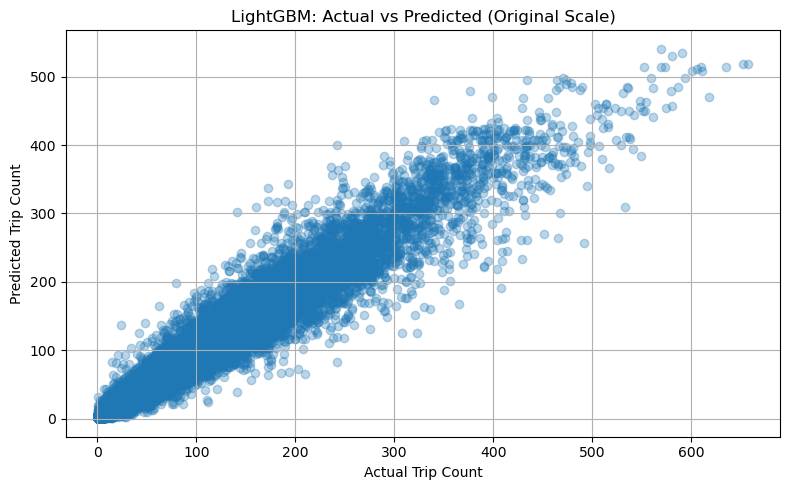

<Figure size 800x600 with 0 Axes>

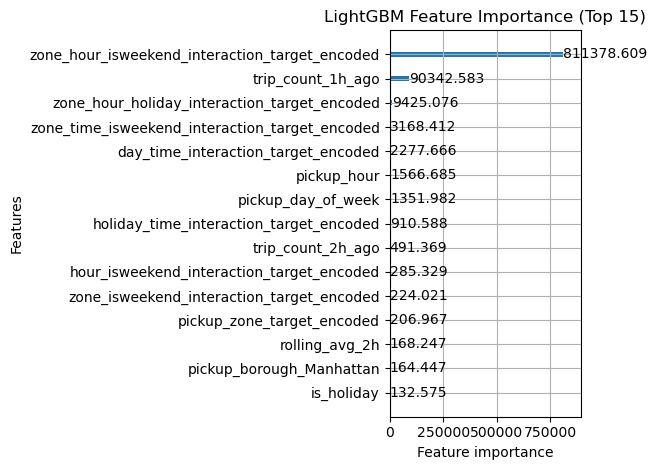

In [36]:
from lightgbm import plot_importance
# Prepare data
X_train = train_encoded.drop(columns='log_trip_count')
y_train = train_encoded['log_trip_count']
X_test = test_encoded.drop(columns='log_trip_count')
y_test = test_encoded['log_trip_count']

# Define LightGBM regression model
model = LGBMRegressor(
    objective='regression',
    verbosity=-1,
    random_state=42
)

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200]
}

# Grid search
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit grid search
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_
log_preds = best_model.predict(X_test)

# Inverse log-transform
y_pred = np.expm1(log_preds)
y_true = np.expm1(y_test)

# Evaluation
print("Best Parameters:", grid.best_params_)
print("Evaluation on Test Set (Original Scale):")
print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
print("MAE:", mean_absolute_error(y_true, y_pred))
print("R² Score:", r2_score(y_true, y_pred))

# Plot actual vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel("Actual Trip Count")
plt.ylabel("Predicted Trip Count")
plt.title("LightGBM: Actual vs Predicted (Original Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature importance
plt.figure(figsize=(8, 6))
plot_importance(best_model.booster_, max_num_features=15, importance_type='gain')
plt.title("LightGBM Feature Importance (Top 15)")
plt.tight_layout()
plt.show()


##### **Evaluation (Conclusion)**
- All models achieve high accuracy, explaining over 96% of variance in trip demand.
- Random Forest relies more on raw temporal signals, while boosting models learn from encoded interaction patterns.
- The consistency across models confirms that both recent demand and zone-hour context are key predictors of taxi activity.